Lazy Probabilistic Roadmap Planners (lazy-PRM)
=============================================

**Topic**: Introduction to PRM planners

Version | Author
------------ | -------------
0.2 | Björn Hein


This worksheet **explains the basic concepts of path planning using a lazy probablistic roadmap approach (lazy-PRM)** 


License is based on Creative Commons: Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) (pls. check: http://creativecommons.org/licenses/by-nc/4.0/)

**Attention**: This worksheet has an external dependency to the file "InnoKonz2DEnv.py". This file contains a simple 2D environment based on numpy arrays and an interface for the use as collision checking in the algorithms.

Important links are:

    General Info: http://www.python.org
    Python tutorial http://www.python.org/doc/tut/
    NetworkX http://networkx.github.io/
    NumPy and SciPy Guide http://docs.scipy.org/
    Matplotlib gallery http://matplotlib.sourceforge.net/gallery.html

Remember that:

    you have to press ctrl-return or shift-return, to execute the code in the code sections, only then the variables are "generated" and can be used
    you can execute the whole notebook by Cell->runAll





In [8]:
    import sys
sys.path.append("templates")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Pre-Info
=======

Before coming to the algorithm itself, a short info about the **zip** function, which is used to generate out of the path list a list of consecutive path segments:


In [9]:
examplePath = [0,1,2,3,4,5,6,7,8]
examplePathSegements = zip(examplePath,examplePath[1:])
print ("Example of Path",list(examplePath))
print ("Example of generated path segments", list(examplePathSegements))


Example of Path [0, 1, 2, 3, 4, 5, 6, 7, 8]
Example of generated path segments [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8)]


Lazy-PRM Algorithm
==============

Following an example implementation of the Lazy-PRM as discussed in the lecture. The only kind of refinement step is a  uniform distribution of new configurations.

In [10]:
from IPPRMBase import PRMBase
from scipy.spatial import cKDTree
import networkx as nx
import random


class LazyPRM(PRMBase):

    def __init__(self, _collChecker):
        """
        _collChecker: the collision checker interface
        """
        self.graph = nx.Graph()
        self._collisionChecker = _collChecker
        self.lastGeneratedNodeNumber = 1
        self.collidingEdges = []
        self.nonCollidingEdges =[]
    
    def _buildRoadmap(self, numNodes, kNearest):
        
        # generate #numNodes nodes
        addedNodes = []
        for i in range(numNodes):
            pos = self._getRandomPosition()
            self.graph.add_node(self.lastGeneratedNodeNumber, pos=pos)
            addedNodes.append(self.lastGeneratedNodeNumber)
            self.lastGeneratedNodeNumber += 1


        # for every node in graph find nearest neigbhours
        posList = list(nx.get_node_attributes(self.graph,'pos').values())
        #print posList
        kdTree = cKDTree(posList)
        
        # to see when _buildRoadmap has to be called again
        #print addedNodes
        for node in addedNodes:
        #for node in self.graph.nodes():
        # Find set of candidates to connect to sorted by distance
            result = kdTree.query(self.graph.nodes[node]['pos'],k=kNearest)
            for data in result[1]:
                c_node = [x for x, y in self.graph.nodes(data=True) if (y['pos']==posList[data])][0]
                if node!=c_node:
                    if (node, c_node) not in self.collidingEdges:
                        self.graph.add_edge(node,c_node)
                    else:
                        continue
                        #print "not adding already checked colliding edge"
    

    def _checkForCollisionAndUpdate(self,path):
        # first check all nodes
        for nodeNumber in path:
            if self._collisionChecker.pointInCollision(self.graph.nodes[nodeNumber]['pos']):
                self.graph.remove_node(nodeNumber)
                #print "Colliding Node"
                return True
        
        # check all path segments
        for elem in zip(path,path[1:]):
            #print elem
            x = elem[0]
            y = elem[1]
            if self._collisionChecker.lineInCollision(self.graph.nodes[x]['pos'],self.graph.nodes[y]['pos']):
                self.graph.remove_edge(x,y)
                self.collidingEdges.append((x,y))
                return True
            else:
                self.nonCollidingEdges.append((x,y))
                                                                                          
            
        return False
        
       
    def planPath(self, startList, goalList, config):
        """
        
        Args:
            startList (array): start position in planning space
            goalList (array) : goal position in planning space
            config (dict): dictionary with the needed information about the configuration options
            
        Example:
        
            config["initialRoadmapSize"] = 40 # number of nodes of first roadmap
            config["updateRoadmapSize"]  = 20 # number of nodes to add if there is no connection from start to end
            config["kNearest"] = 5 # number of nodes to connect to during setup
        """
        # 0. reset
        self.graph.clear()
        self.lastGeneratedNodeNumber = 0
        self.collidingEdges = []
        
        # 1. check start and goal whether collision free (s. BaseClass)
        checkedStartList, checkedGoalList = self._checkStartGoal(startList,goalList)
        
        # 2. add start and goal to graph
        self.graph.add_node("start", pos=checkedStartList[0])
        self.graph.add_node("goal", pos=checkedGoalList[0])
        
        # 3. build initial roadmap
        self._buildRoadmap(config["initialRoadmapSize"], config["kNearest"])
        
        maxTry = 0
        while maxTry < config["maxIterations"]: 
            try:
                path = nx.shortest_path(self.graph,"start","goal")
            except:
                self._buildRoadmap(config["updateRoadmapSize"], config["kNearest"])
                maxTry += 1
                continue
              
            if self._checkForCollisionAndUpdate(path):
                continue
            else:
                #print "Found solution"
                return path
            
        return []


Tests
=========

**Remark**: A visulizer for the Lazy-PRM is provided by the module *InnoKonzVisualizer*.

In [11]:

def lazyPRMVisualize(origGraph, collChecker, solution = [], collEdges = [], nonCollEdges=[], ax=None):
    graph = origGraph.copy()
    # get a list of positions of all nodes by returning the content of the attribute 'pos'
    pos = nx.get_node_attributes(graph,'pos')
    color = nx.get_node_attributes(graph,'color')

    if collEdges != []:
        collGraph = nx.Graph()
        collGraph.add_nodes_from(origGraph.nodes(data=True))

        #collGraph
        for i in collEdges:
            collGraph.add_edge(i[0],i[1])
        nx.draw_networkx_edges(collGraph,pos,alpha=0.2,edge_color='r',width=5)

    
    # get a list of degrees of all nodes
    #degree = nx.degree_centrality(graph)
    
    # draw graph (nodes colorized by degree)
    nx.draw(graph, pos = pos, node_color = list(color.values()))
    
    # draw all connected components, emphasize the largest one
    Gcc=(graph.subgraph(c) for c in nx.connected_components(graph))
    G0=next(Gcc) # [0] = largest connected component
    
    # how largest connected component
    nx.draw_networkx_edges(G0,pos,
                               edge_color='b',
                               width=3.0, style='dashed',
                               alpha=0.5,
                            )

    if nonCollEdges != []:
        nonCollGraph = nx.Graph()
        nonCollGraph.add_nodes_from(origGraph.nodes(data=True))

        #collGraph
        for i in nonCollEdges:
            nonCollGraph.add_edge(i[0],i[1])
        nx.draw_networkx_edges(nonCollGraph,pos,alpha=0.8,edge_color='yellow',width=5)

    
    
    # show other connected components
    for Gi in Gcc:
       if len(Gi)>1:
          nx.draw_networkx_edges(Gi,pos,
                                 edge_color='b',
                                 alpha=0.1,
                                 width=1.0
                                 )
    
    

    collChecker.drawObstacles(ax)
    
    # draw start and goal
    # draw start and goal
    if "start" in graph.nodes(): 
        nx.draw_networkx_nodes(graph,pos,nodelist=["start"],
                                   node_size=300,
                                   node_color='#00dd00',  ax = ax)
    if "goal" in graph.nodes():
        nx.draw_networkx_nodes(graph,pos,nodelist=["goal"],
                                   node_size=300,
                                   node_color='#00dd00',  ax = ax)

    if solution != []:
        # draw nodes based on solution path
        Gsp = nx.subgraph(graph,solution)
        #nx.draw_networkx_nodes(Gsp,pos,
        #                        node_size=300,
        #                         node_color='g')

        # draw edges based on solution path
        nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10)
    

    
    return


In [12]:
import IPTestSuite

In [13]:
benchList = IPTestSuite.benchList

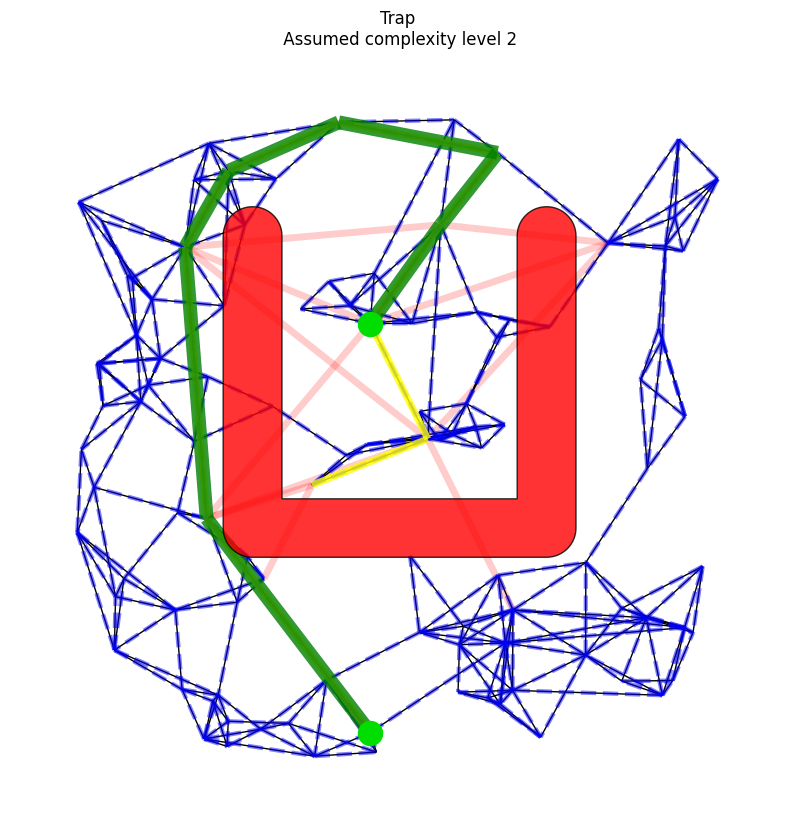

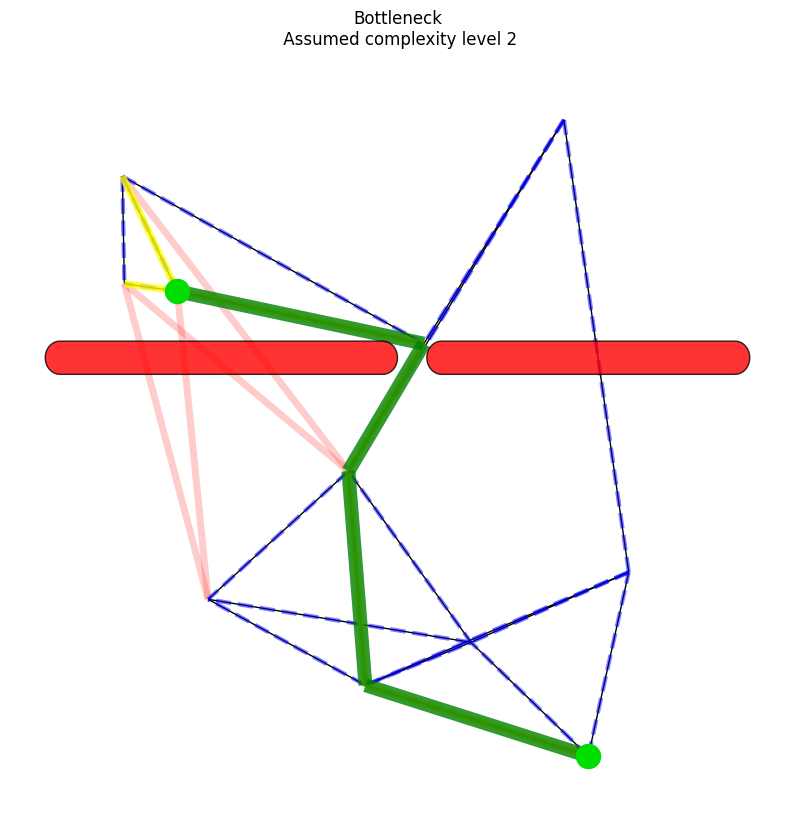

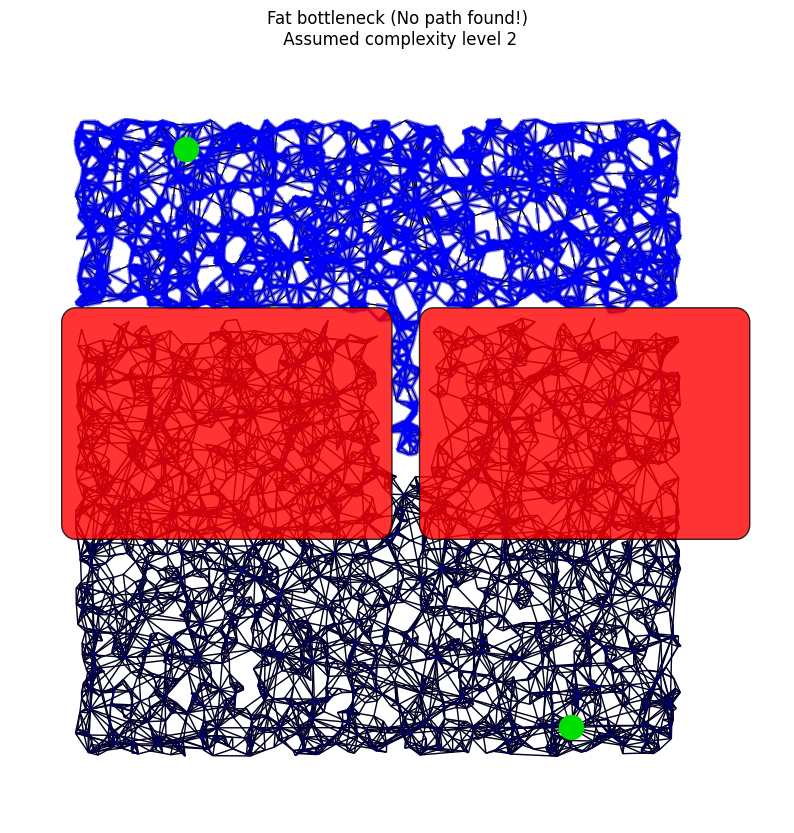

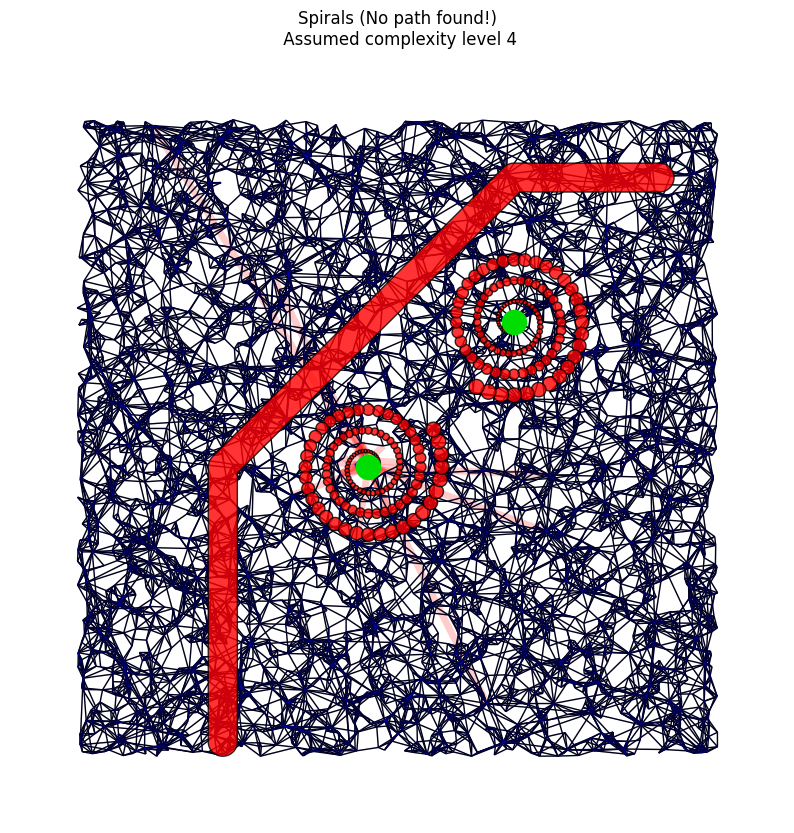

In [21]:
lazy = LazyPRM(environment)
lazyConfig = dict()
lazyConfig["initialRoadmapSize"] = 10 # number of nodes of first roadmap
lazyConfig["updateRoadmapSize"]  = 50 # number of nodes to add if there is no connection from start to end
lazyConfig["kNearest"] = 5 # number of nodes to connect to during setup
lazyConfig["maxIterations"] = 100 # number of nodes to connect to during setup

for bench in benchList:
    try:
        fig_local = plt.figure(figsize=(10,10))
        ax = fig_local.add_subplot(1,1,1)
        lazy = LazyPRM(bench.collisionChecker)
        solution = lazy.planPath(bench.startList, bench.goalList, lazyConfig)
        title = bench.name
        if solution == []:
            title += " (No path found!)"
        title += "\n Assumed complexity level " + str(bench.level)
        ax.set_title(title)
        lazyPRMVisualize(lazy.graph, lazy._collisionChecker, solution, lazy.collidingEdges, lazy.nonCollidingEdges, ax=ax)
    except Exception as e:
        print("ERROR: ",bench.name, e)

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

from shapely.geometry import Point, Polygon, LineString
from IPEnvironment import CollisionChecker

# Definition of a testing environment
trapField = dict()
trapField["obs1"] =   LineString([(6, 18), (6, 8), (16, 8), (16,18)]).buffer(1.0)

environment = CollisionChecker(trapField)



mystart = [[1,20]]
myend = [[20,1]]

# Visibility
lazy = LazyPRM(environment)
lazyConfig = dict()
lazyConfig["initialRoadmapSize"] = 20 # number of nodes of first roadmap
lazyConfig["updateRoadmapSize"]  = 30 # number of nodes to add if there is no connection from start to end
lazyConfig["kNearest"] = 5 # number of nodes to connect to during setup

#environment.resetCounter()
solution = lazy.planPath(mystart, myend, lazyConfig)
#title = "Lazy-PRM"
#if solution == []:
#    title += " (No path found!)"

fig = plt.figure(figsize=(18,18))
ax = plt.subplot(111)


lazyPRMVisualize(lazy.graph, lazy._collisionChecker, solution, lazy.collidingEdges, lazy.nonCollidingEdges, ax=ax)


KeyError: 'maxIterations'